<h1 style="font-size: 40px; text-align:center;">VIC: Introduction to Visual Computing - 2022-23 </h1>

# Summary

0. [Project Outline](#Project-Outline)
1. [Libraries](#Libraries)
2. [Dataset](#Dataset)
3. [Video Building](#Video-Building)
4. [Data Preprocessing](#Data-Preprocessing)


## Project Outline



**Instructor:** Maria Vakalopoulou </br>
**T.A.:** Joseph Boyd </br>
**Due Date:** March 15, 2023 </br>

This is VIC Assignment 2. This time you are to implement a system that outputs object detection bounding boxes of cars in a dashcam videos. You are expected to submit your prediction to a Kaggle challenge at the following link, where you will also find the dataset and further instructions:

https://www.kaggle.com/t/d4ce01f69c874429b9f467595a2b3f8c

You have a set of frames available for training in the `train/` directory, and their bounding boxes in `train.csv`, having format:

```x, y, width, height```

Your task is to produce bounding boxes for each frame in the `test/` directory.  **N.B.** Because of limitations of in-class Kaggle, your final submission file will be of a slightly different format to `train.csv`.

### Evaluation

Submissions are evaluated with respect to the Sørensen–Dice coefficient,

$$DSC = \frac{2|X \cap Y|}{|X| + |Y|},$$

the intersection of the prediction X and the ground truth solution Y over the sum of their parts. The minimum is 0 (no intersection), and the maximum is 1 (perfect overlap). The mean DSC over all test images is your final score. **N.B.** that although the challenge is posed as an object detection problem, it is evaluated as a segmentation problem i.e. X and Y will be binary masks (see below). This is due to some limitations of Kaggle as used in-class mode.

An unspecified 50% split of the test data contributes to a "public leaderboard", with the remaining data contributing to a "private leaderboard", which is not visible until the end of the competition. This is to prevent overfitting to the test data.

### Submitting to Kaggle

Submissions to the Kaggle challenge can be made in the form of a .csv file (see `sample_submission.csv`), consisting of two columns with one row per image:
```
Id,Predicted
test/001.jpg,192425 100 193705 100 ...
test/002.jpg,192425 100 193705 100 ...
test/003.jpg,192425 100 193705 100 ...
...
```
`Id` - the image id, which is the path to the image from the project root--must be exact.

`Predicted` - The [run length encoding](https://en.wikipedia.org/wiki/Run-length_encoding) of the binary mask resulting from your concatenated bounding boxes. It is recommended to use the supplied function `run_length_encoding` to automate this. An example is given in the `Assignment2.ipynb` notebook. **N.B.** If you change the size of the images during your pipeline, be sure to resize your final bounding boxes to  (1280x720).

### Grading

Your work will be evaluated according to the following:

- Solution design (40%): algorithmic complexity, technical innovation, performance (as evaluated on Kaggle). Simple ideas can achieve full marks if they are well-argued and perform well.

- Implementation (40%): code quality, efficiency, clarity of documentation (code should be well commented). You should submit all code required to train/test your pipeline in a `.ipynb` notebook or a set of `.py` file(s).

- Report (~1 page) (20%): Description of pipeline and justification of design choices, results and failure cases. In general, we want to know why you did one thing and not another.

**PLUS** the best 5 leaderboard submissions will receive +1 for the grade of the assignment.

**N.B.** This is an individual assignment. All students are expected to make at least one Kaggle submission and submit their own project code and report.

You should send your assignment by email to maria.vakalopoulou@centralesupelec.fr, the name of the subject of the email should be: VIC\_Assignment2\_name.

### FAQ

**Q:** Can I use external datasets?</br>
**A:** Yes.

**Q:** Must I code algorithms from scratch?</br>
**A:** You will be graded on the design/implementation of your solution pipeline, which ordinarily will comprise multiple algorithms (e.g. filters, features, machine learning). Unlike the labs and previous assignment, you are not required to code these individual algorithms from scratch.

**Q:** Can my pipeline take a long time to run?</br>
**A:** It is acceptable if your training and/or testing takes some hours to run. However, in this case you should argue convincingly in your report that this is fully warranted.

**Q:** Can I use deep learning?</br>
**A:** You are quite free in the design of your solution pipeline. However, **NO DEEP LEARNING APPROACHES ARE ALLOWED**. You should use classic methods to complete this assignment!

# Libraries

In [1]:
import cv2
import numpy as np
import glob
import pandas as pd
import os
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from skimage.io import imread
from ipywidgets import interact, widgets
from IPython.display import display
from skimage.feature import hog
from skimage import exposure
import time
from tqdm import tqdm
import random
import math
import json
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import pickle
from scipy.ndimage import label
from collections import deque
from moviepy.editor import VideoFileClip

# Local imports
from src.utils.annotate import draw_bounding_boxes, draw_annotation, show_annotation, read_frame, extract_vehicle_images_from_bboxs
from src.utils.preprocessing import convert_color
from src.utils.load_data import load_train_csv, get_images
from src.utils.extract_features import extract_features, save_features
from src.utils.bbox_to_mask import bounding_boxes_to_mask, run_length_encoding


from src.classes.color_extractor import ColorFeaturesExtractor
from src.classes.hog_extractor import HoGFeaturesExtractor
from src.classes.spatial_extractor import SpatialFeaturesExtractor
from src.classes.vehicle_detector import VehicleDetector
from src.classes.vehicle_classifier import VehicleClassifier

%matplotlib inline
%load_ext autoreload
%reload_ext autoreload

# Params

In [2]:
# Open JSON paramerters file
with open('./config/params.json') as f:
    params = json.load(f)
pprint(params)

{'classifier': 'LinearSVC',
 'color_features_settings': {'color_histogram_bins': 64,
                             'color_histogram_range': [0, 256],
                             'extract_color_features': False},
 'color_space': 'RGB',
 'file_names': {'datasets': 'train_test_datasets',
                'non_vehicle_features': 'non_vehicle_features',
                'vehicle_features': 'vehicle_features'},
 'heatmap': {'heat_queue_length': 1, 'heatmap_threshold': 6},
 'hog_features_settings': {'cells_per_block': [2, 2],
                           'extract_hog_features': True,
                           'hog_channel_to_extract': 'all',
                           'hog_orientations': 9,
                           'pixels_per_cell': [7, 7]},
 'paths': {'path_to_csv': './data/initial/train.csv',
           'path_to_frames': './data/initial/raw/frames/',
           'path_to_models': './models/',
           'path_to_videos': './data/initial/raw/videos/'},
 'predict_proba': True,
 'sliding_window

In [3]:
# Parameters variables
COLOR_SPACE = params['color_space']

# Spatial binning parameters
EXTRACT_SPATIAL_FEATURES = params['spatial_features_settings']['extract_spatial_features']
SPATIAL_SIZE = tuple(params['spatial_features_settings']['spatial_size'])

# Color histogram parameters
EXTRACT_COLOR_FEATURES = params['color_features_settings']['extract_color_features']
COLOR_HISTOGRAM_BINS = params['color_features_settings']['color_histogram_bins']
COLOR_HISTOGRAM_RANGE = tuple(params['color_features_settings']['color_histogram_range'])

# HoG parameters
EXTRACT_HOG_FEATURES = params['hog_features_settings']['extract_hog_features']
HOG_ORIENTATIONS = params['hog_features_settings']['hog_orientations']
PIXELS_PER_CELL = tuple(params['hog_features_settings']['pixels_per_cell'])
CELLS_PER_BLOCK = tuple(params['hog_features_settings']['cells_per_block'])
HOG_CHANNEL_TO_EXTRACT = params['hog_features_settings']['hog_channel_to_extract']

PATH_TO_CSV = params["paths"]["path_to_csv"]
PATH_TO_FRAMES = params["paths"]["path_to_frames"]
PATH_TO_VIDEOS = params["paths"]["path_to_videos"]

# Model params variables
TEST_SIZE = params['test_size']
CLASSIFIER = params['classifier'] # "LinearSVC", "SVC", "RandomForestClassifier", "AdaBoost", "XGBoost", "GradientBoosting","PCA"
FILENAME_datasets = params['file_names']['datasets']
FILENAME_vehicle_features = params['file_names']['vehicle_features']
FILENAME_non_vehicle_features = params['file_names']['non_vehicle_features']
PATH_TO_MODELS  = params["paths"]['path_to_models']

# Data Preprocessing

In [4]:
df_ground_truth, no_bbox_counter = load_train_csv(path_to_csv=PATH_TO_CSV,path_to_frames=PATH_TO_FRAMES)
print(f"Number of frames without bounding boxes: {no_bbox_counter}")
df_ground_truth.head()

Number of frames without bounding boxes: 364


,frame_id,bounding_boxes
0,./data/initial/raw/frames/train/A_001.jpg,"[[0.0, 225.0, 214.0, 317.0], [0.0, 172.0, 345...."
1,./data/initial/raw/frames/train/A_002.jpg,"[[0.0, 254.0, 190.0, 293.0], [0.0, 169.0, 338...."
2,./data/initial/raw/frames/train/A_003.jpg,"[[0.0, 306.0, 59.0, 241.0], [0.0, 155.0, 306.0..."
3,./data/initial/raw/frames/train/A_004.jpg,"[[0.0, 143.0, 239.0, 298.0], [164.0, 223.0, 24..."
4,./data/initial/raw/frames/train/A_005.jpg,"[[0.0, 217.0, 137.0, 270.0], [55.0, 209.0, 323..."


In [5]:
H, W = 720, 1280
N = len(df_ground_truth)

In [6]:
def f_display(frame_id):
    show_annotation(df_ground_truth, frame_id)

interact(f_display, frame_id=widgets.IntSlider(min=0, max=N-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='frame_id', max=2221), Output()), _dom_classes=('widget-i…

<function __main__.f_display(frame_id)>

In [7]:
extract_vehicle_images_from_bboxs(csv_df=df_ground_truth, resolution= (64, 64))

  3%|▎         | 56/2222 [00:02<01:25, 25.38it/s]


KeyboardInterrupt: 

In [7]:
# Pathways to the images
INITIAL_VEHICLES = './data/initial/vehicles/**/*.png'
INITIAL_NON_VEHICLES = './data/initial/non-vehicles/**/*.png'
UDACITY_VEHICLES = './data/udacity/vehicles/**/*.png'
UDACITY_NON_VEHICLES = './data/udacity/non-vehicles/**/*.png'

# Use glob to get the list of imgs
vehicle_imgs = get_images(UDACITY_VEHICLES) #+ get_images(INITIAL_VEHICLES)
non_vehicle_imgs = get_images(INITIAL_NON_VEHICLES) + get_images(UDACITY_NON_VEHICLES)

Number of vehicle images: 8792
Image size: (64, 64, 3)
Nb of channels: 3
Number of non-vehicle images: 8968
Image size: (64, 64, 3)
Nb of channels: 3


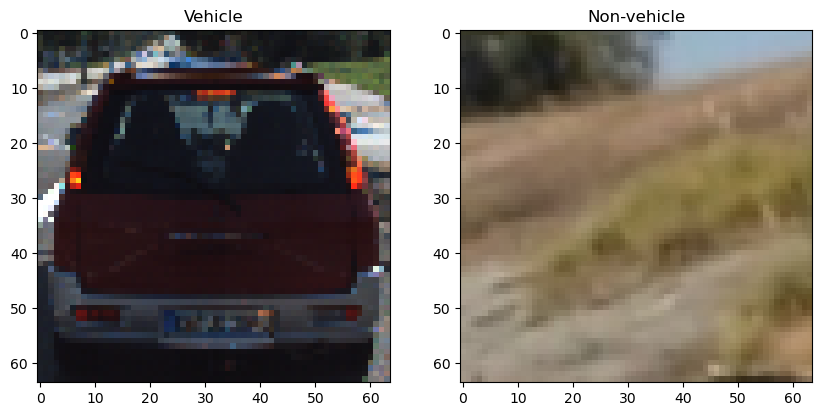

In [8]:
# Display information about the dataset
print("="*50)
print(f"Number of vehicle images: {len(vehicle_imgs)}")
print(f"Image size: {vehicle_imgs[0].shape}")
print(f"Nb of channels: {vehicle_imgs[0].shape[2]}")
print("="*50)
print(f"Number of non-vehicle images: {len(non_vehicle_imgs)}")
print(f"Image size: {non_vehicle_imgs[0].shape}")
print(f"Nb of channels: {non_vehicle_imgs[0].shape[2]}")

# Display a random vehicle image
_vehicleimg = random.choice(vehicle_imgs)
_nonvehicleimg = random.choice(non_vehicle_imgs)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_title("Vehicle")
axes[0].imshow(_vehicleimg)
axes[1].set_title("Non-vehicle")
axes[1].imshow(_nonvehicleimg)

# Video Building

### Test Raw Video

In [10]:
frameSize = (1280,720)

out = cv2.VideoWriter(PATH_TO_VIDEOS + 'test_raw.mp4',cv2.VideoWriter_fourcc(*'avc1'), 9, frameSize)

#for filename in glob.glob('./test/*.jpg'):
# Loop through the image frames in the dataset
for i in tqdm(range(1, len(os.listdir('./data/initial/raw/frames/test')))):
    # Check if the frame exists
    if os.path.exists(f'./data/initial/raw/frames/test/{i:0>3}.jpg'):
        # Read the image frame
        frame = cv2.imread(f'./data/initial/raw/frames/test/{i:0>3}.jpg')
        out.write(frame)

out.release()

100%|██████████| 201/201 [00:03<00:00, 57.80it/s]


### Train Raw Videos

In [11]:
frameSize = (1280,720)

video_types = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J','K']

for x in video_types:
    out = cv2.VideoWriter(PATH_TO_VIDEOS + f'train_{x}_raw.mp4',cv2.VideoWriter_fourcc(*'avc1'), 9, frameSize)
    for i in tqdm(range(1, len(os.listdir('./data/initial/raw/frames/train')))):
        # Check if the frame exists
        if os.path.exists(f'./data/initial/raw/frames/train/{x}_{i:0>3}.jpg'):
            # Read the image frame
            frame = cv2.imread(f'./data/initial/raw/frames/train/{x}_{i:0>3}.jpg')
            out.write(frame)

out.release()

100%|██████████| 2221/2221 [00:03<00:00, 618.24it/s] 


### Train Annotated Videos

In [12]:
frameSize = (1280,720)

out = cv2.VideoWriter(PATH_TO_VIDEOS + 'train_annotated_full_raw.mp4',cv2.VideoWriter_fourcc(*'avc1'), 9, frameSize)
for i in tqdm(range(0, len(os.listdir('./data/initial/raw/frames/train'))-1)):
    # Read the image frame
    frame = draw_annotation(df_ground_truth, i)
    # Convert BGR to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    out.write(frame)

out.release()

100%|██████████| 2221/2221 [00:55<00:00, 40.32it/s]


# Features Vizualization

#### Spatial Bin Features

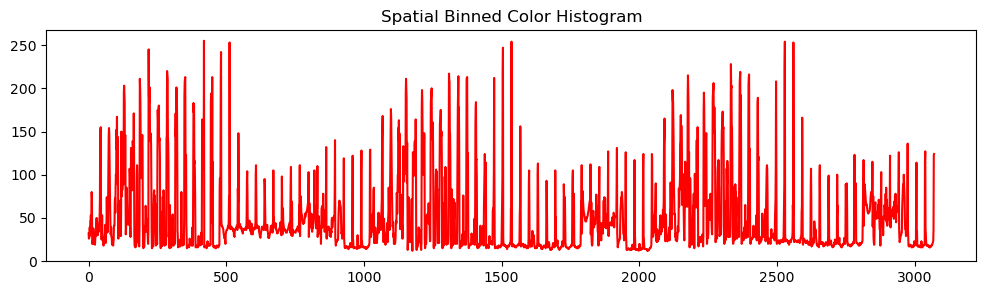

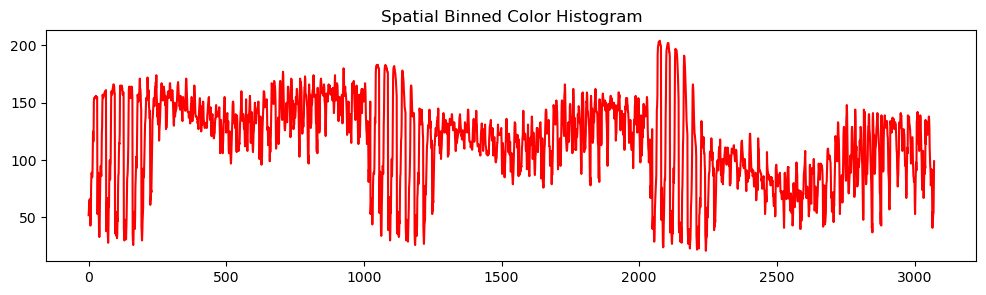

In [9]:
spatial_features_extractor = SpatialFeaturesExtractor(size=SPATIAL_SIZE)
vehicle_spatial_features, vehicle_spatial_hist = spatial_features_extractor.extract(img=_vehicleimg,visualize=True)
non_vehicle_spatial_features, non_vehicle_spatial_hist = spatial_features_extractor.extract(img=_nonvehicleimg,visualize=True)

#### Color Histogram Features

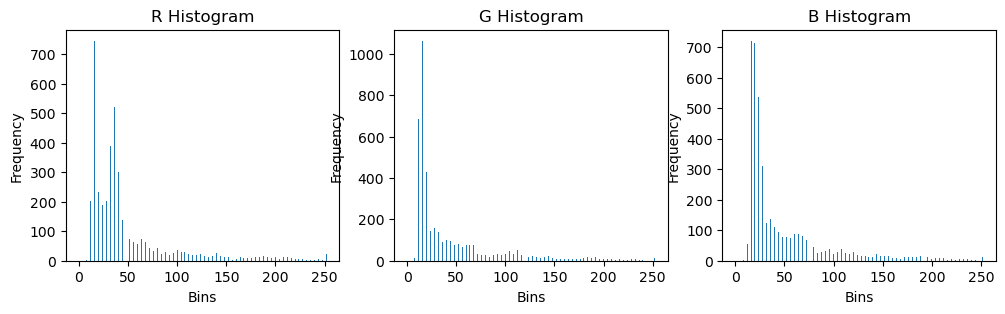

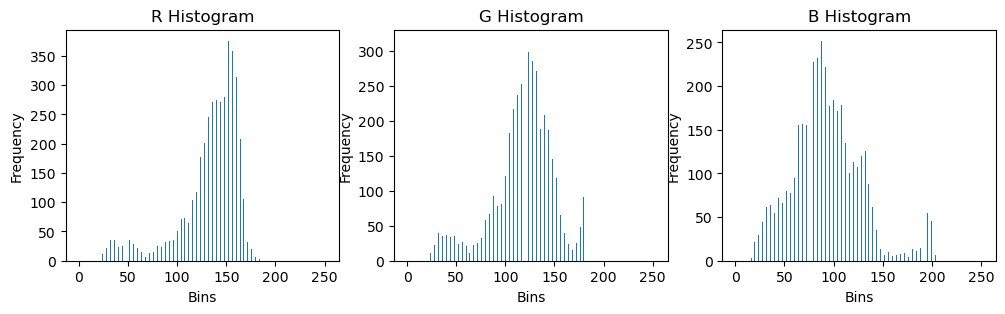

In [10]:
color_hist_features_extractor = ColorFeaturesExtractor(n_bins = COLOR_HISTOGRAM_BINS, histogram_range = COLOR_HISTOGRAM_RANGE)
vehicle_color_hist_features, vehicle_color_hist = color_hist_features_extractor.extract(img=_vehicleimg,visualize=True)
non_vehicle_color_hist_features, non_vehicle_color_hist = color_hist_features_extractor.extract(img=_nonvehicleimg,visualize=True)

#### Histogram of Oriented Gradients Features

HoG settings:
Pixels per cell:  (7, 7)
Cells per block:  (2, 2)
Orientations:  9


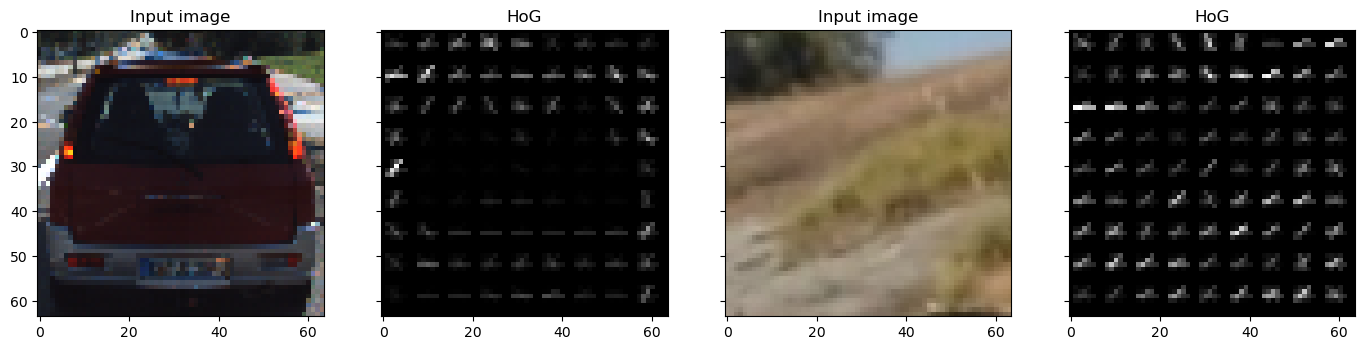

In [11]:
hog_features_extractor = HoGFeaturesExtractor(orientations=HOG_ORIENTATIONS, pixels_per_cell=PIXELS_PER_CELL, cells_per_block=CELLS_PER_BLOCK, channel_to_extract=HOG_CHANNEL_TO_EXTRACT)
vehicle_hog_features, vehicle_hog_image = hog_features_extractor.extract(img=_vehicleimg,visualize=True)
non_vehicle_hog_features, non_vehicle_hog_image = hog_features_extractor.extract(img=_nonvehicleimg,visualize=True)

print("="*50)
print("HoG settings:")
print("Pixels per cell: ", PIXELS_PER_CELL)
print("Cells per block: ", CELLS_PER_BLOCK)
print("Orientations: ", HOG_ORIENTATIONS)
print("="*50)

fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(17, 12), sharex=True, sharey=True)

ax1.imshow(_vehicleimg, cmap=plt.cm.gray)
ax1.set_title('Input image')

ax2.imshow(vehicle_hog_image, cmap=plt.cm.gray)
ax2.set_title('HoG')

ax3.imshow(_nonvehicleimg, cmap=plt.cm.gray)
ax3.set_title('Input image')

ax4.imshow(non_vehicle_hog_image, cmap=plt.cm.gray)
ax4.set_title('HoG')

plt.show()


# Features Extraction

In [12]:
vehicles_features = extract_features(path=vehicle_imgs, color_space=COLOR_SPACE, spatial_size=SPATIAL_SIZE, color_histogram_bins= COLOR_HISTOGRAM_BINS, hog_orientations = HOG_ORIENTATIONS, pixels_per_cell = PIXELS_PER_CELL, cells_per_block=CELLS_PER_BLOCK, hog_channel_to_extract = HOG_CHANNEL_TO_EXTRACT, extract_spatial_features=EXTRACT_SPATIAL_FEATURES, extract_color_features=EXTRACT_COLOR_FEATURES, extract_hog_features=EXTRACT_HOG_FEATURES, color_histogram_range=COLOR_HISTOGRAM_RANGE)
non_vehicles_features = extract_features(path=non_vehicle_imgs, color_space=COLOR_SPACE, spatial_size=SPATIAL_SIZE, color_histogram_bins= COLOR_HISTOGRAM_BINS, hog_orientations = HOG_ORIENTATIONS, pixels_per_cell = PIXELS_PER_CELL, cells_per_block=CELLS_PER_BLOCK, hog_channel_to_extract = HOG_CHANNEL_TO_EXTRACT, extract_spatial_features=EXTRACT_SPATIAL_FEATURES, extract_color_features=EXTRACT_COLOR_FEATURES, extract_hog_features=EXTRACT_HOG_FEATURES, color_histogram_range=COLOR_HISTOGRAM_RANGE)

100%|██████████| 8968/8968 [01:18<00:00, 114.56it/s]


In [13]:
print("="*50)
print("Type of vehicle_features variable: ", type(vehicles_features))
print("Shape of vehicle_features variable: ", np.shape(vehicles_features))
print("="*50)
print("Type of non_vehicle_features variable: ", type(non_vehicles_features))
print("Shape of non_vehicle_features variable: ", np.shape(non_vehicles_features))

Type of vehicle_features variable:  <class 'list'>
Shape of vehicle_features variable:  (8792, 6912)
Type of non_vehicle_features variable:  <class 'list'>
Shape of non_vehicle_features variable:  (8968, 6912)


In [14]:
save_features(path='./models/', file_name=params['file_names']['vehicle_features'], features=vehicles_features)
save_features(path='./models/', file_name=params['file_names']['non_vehicle_features'], features=non_vehicles_features)

Saving features to pickle file ./models/vehicle_features.pkl...
Features cached in pickle file.
Saving features to pickle file ./models/non_vehicle_features.pkl...
Features cached in pickle file.


# Vehicle Classifier

In [15]:
#### VEHICLES

# Load file
file = open(PATH_TO_MODELS + FILENAME_vehicle_features + '.pkl', 'rb')
vehicle_data = pickle.load(file)
file.close()

# Retrieve features by loading pickle files
vehicles_features = vehicle_data['features']

#### NON VEHICLES

# Load file
file = open(PATH_TO_MODELS + FILENAME_non_vehicle_features + '.pkl', 'rb')
non_vehicle_data = pickle.load(file)
file.close()

# Retrieve features by loading pickle files
non_vehicles_features = non_vehicle_data['features']

In [16]:
vehicle_classifier = VehicleClassifier(vehicle_features=vehicles_features,non_vehicle_features=non_vehicles_features)
X_train, X_test, y_train, y_test, scaler = vehicle_classifier.build_train_test_sets(test_size=TEST_SIZE, random_state=42)
print("="*20 +  "Train set" + "="*20)
print("="*50)
print("Shape of X_train variable: ", np.shape(X_train))
print("Shape of y_train variable: ", np.shape(y_train))
print("-"*50)
print("Number of cars in train set: ", np.sum(y_train == 1))
print("Number of non-cars in train set: ", np.sum(y_train == 0))
print("="*20 +  "Test set" + "="*20)
print("="*50)
print("Shape of X_test variable: ", np.shape(X_test))
print("Shape of y_test variable: ", np.shape(y_test))
print("-"*50)
print("Number of cars in test set: ", np.sum(y_test == 1))
print("Number of non-cars in test set: ", np.sum(y_test == 0))

====================Train set====================
Shape of X_train variable:  (13320, 6912)
Shape of y_train variable:  (13320,)
--------------------------------------------------
Number of cars in train set:  6594
Number of non-cars in train set:  6726
====================Test set====================
Shape of X_test variable:  (4440, 6912)
Shape of y_test variable:  (4440,)
--------------------------------------------------
Number of cars in test set:  2198
Number of non-cars in test set:  2242


In [17]:
vehicle_classifier.save_datasets(path='./models/',file_name=FILENAME_datasets)

Saving data to pickle file ./models/train_test_datasets.pkl...
Data cached in pickle file.


In [18]:
clf = vehicle_classifier.train(clf=CLASSIFIER, path_to_save=PATH_TO_MODELS)

==============================TRAINING==============================
Training LinearSVC...
Feature vector length: 6912
13.92 seconds to train LinearSVC...
==============================METRICS==============================
Training Accuracy of LinearSVC =  1.0
Test Accuracy of LinearSVC =  0.9718
==============================Saving model...==============================
Model saved in ./models/LinearSVC.pkl


# Vehicle Detector

In [19]:
# Load classifier and parameters
with open(PATH_TO_MODELS + CLASSIFIER + '.pkl', mode='rb') as f:
    data = pickle.load(f)
    print(f"{CLASSIFIER} classifier loaded!")
    
model = data['model']
scaler = data['scaler']

LinearSVC classifier loaded!


In [20]:
# Instantiate VehicleDetector class
vehicle_detector = VehicleDetector(color_space=COLOR_SPACE,
        spatial_size=SPATIAL_SIZE,
        color_histogram_bins=COLOR_HISTOGRAM_BINS,
        hog_orientations=HOG_ORIENTATIONS,
        pixels_per_cell=PIXELS_PER_CELL,
        cells_per_block=CELLS_PER_BLOCK,
        hog_channel_to_extract=HOG_CHANNEL_TO_EXTRACT,
        extract_spatial_features=EXTRACT_SPATIAL_FEATURES,
        extract_color_features=EXTRACT_COLOR_FEATURES,
        extract_hog_features=EXTRACT_HOG_FEATURES,
        color_histogram_range=COLOR_HISTOGRAM_RANGE)

In [21]:
WINDOW_SEARCH_AREAS = params['sliding_window_settings']['window_search_areas']
WINDOW_SIZES = params['sliding_window_settings']['window_sizes']
WINDOW_OVERLAP = params['sliding_window_settings']['window_overlap']
PREDICT_PROBA = params['predict_proba']

HEAT_QUEUE_LENGTH = params['heatmap']['heat_queue_length']
HEATMAP_THRESHOLD = params['heatmap']['heatmap_threshold']

23.62 seconds to detect vehicles


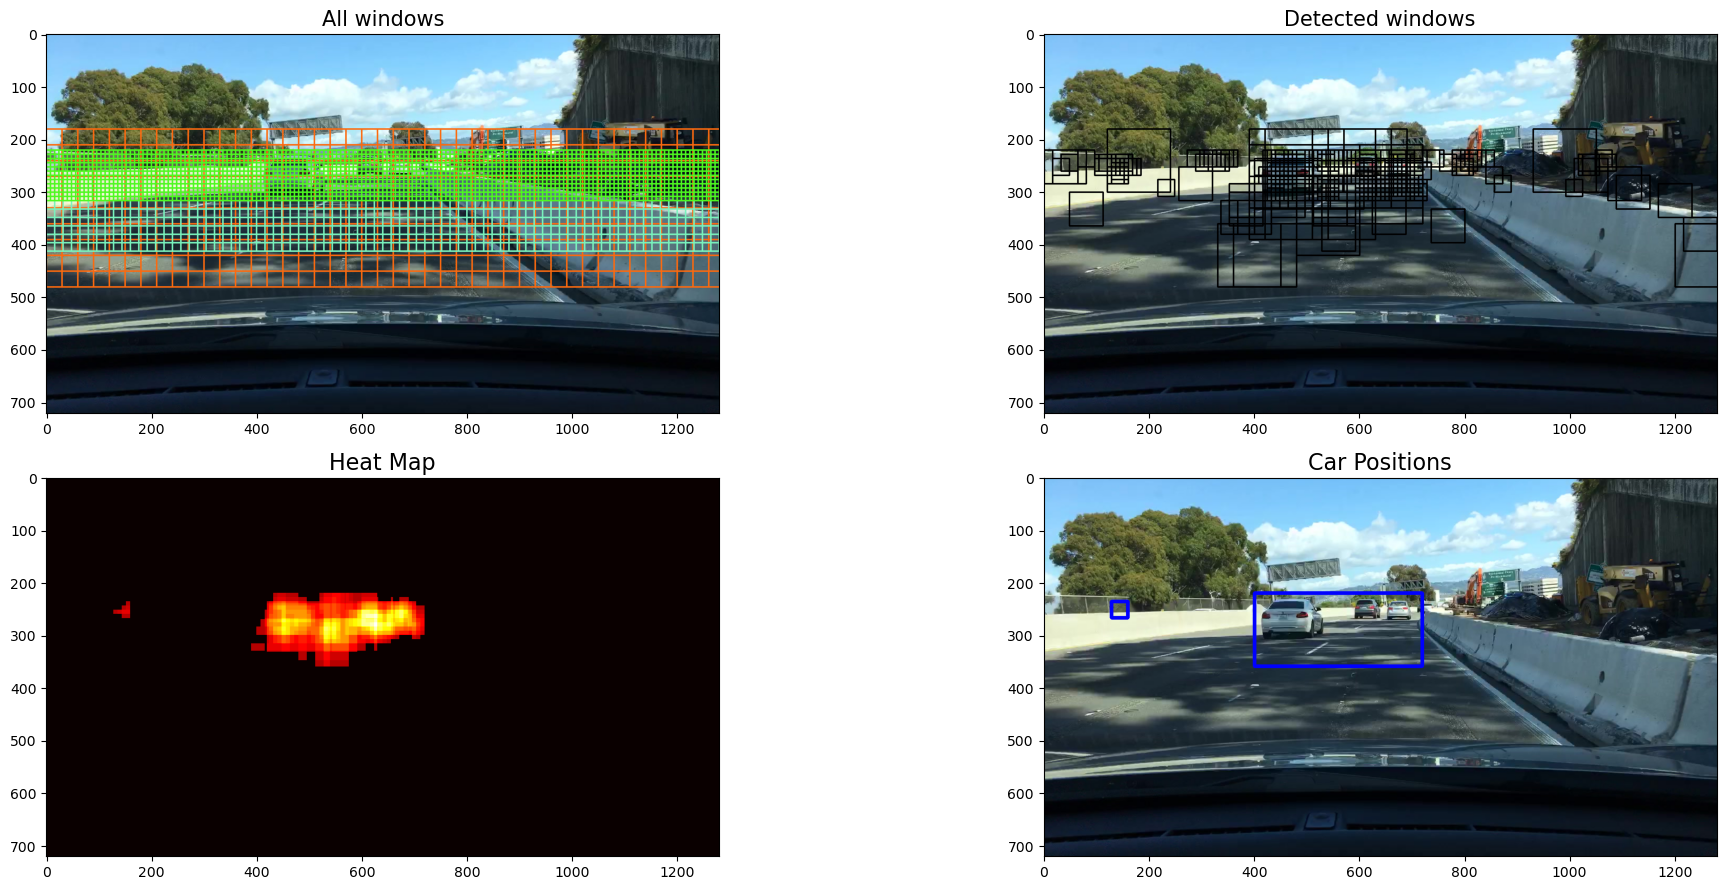

In [22]:
for img in sorted(glob.glob(PATH_TO_FRAMES + 'test/001.jpg')):
#for img in sorted(glob.glob('./test1.jpg')):

    heat_queue = deque(maxlen=HEAT_QUEUE_LENGTH)
    
    allwindows_img, window_img, heatmap, draw_img, bounding_boxes, time_to_detect  = vehicle_detector.analyse_frame(frame=img,window_search_areas=WINDOW_SEARCH_AREAS,window_sizes=WINDOW_SIZES,overlap=WINDOW_OVERLAP,clf=model, scaler=scaler,proba=PREDICT_PROBA,heat_queue=heat_queue,threshold=HEATMAP_THRESHOLD)
    
    print(f"Time to detect: {time_to_detect:.2f} seconds")
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 9))
    fig.tight_layout()

    ax1.imshow(allwindows_img)
    ax1.set_title("All windows", fontsize=15)

    ax2.imshow(window_img)
    ax2.set_title("Detected windows", fontsize=15)

    ax3.imshow(heatmap, cmap="hot")
    ax3.set_title("Heat Map", fontsize=16)

    ax4.imshow(draw_img)
    ax4.set_title("Car Positions", fontsize=16)

    fig.tight_layout()
    
    plt.show()

# Video Processing

In [23]:
frameSize = (1280,720)
avg_time_to_detect = []

out = cv2.VideoWriter('test_output_2.mp4',cv2.VideoWriter_fourcc(*'avc1'), 9, frameSize)

#for filename in glob.glob('./test/*.jpg'):
# Loop through the image frames in the dataset
for i in tqdm(range(1, len(os.listdir('./data/initial/raw/frames/test')))):
    # Check if the frame exists
    if os.path.exists(f'./data/initial/raw/frames/test/{i:0>3}.jpg'):
        # Read the image frame
        frame_dir = f'./data/initial/raw/frames/test/{i:0>3}.jpg'
        _, _, _, output_img, _, time_to_detect = vehicle_detector.analyse_frame(frame=frame_dir,window_search_areas=WINDOW_SEARCH_AREAS,window_sizes=WINDOW_SIZES,overlap=WINDOW_OVERLAP,clf=model, scaler=scaler,proba=PREDICT_PROBA,heat_queue=heat_queue,threshold=HEATMAP_THRESHOLD)
        output_img = cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR)
        out.write(output_img)
        avg_time_to_detect.append(time_to_detect)

print(f"Average time to detect: {np.mean(avg_time_to_detect):.2f} seconds")
out.release()

  0%|          | 1/201 [00:22<1:16:25, 22.93s/it]

22.84 seconds to detect vehicles


  0%|          | 1/201 [00:32<1:48:50, 32.65s/it]


KeyboardInterrupt: 

In [12]:
from IPython.display import HTML

HTML("""
    <video alt="test" controls>
        <source src="test_output_2.mp4" type="video/mp4">
    </video>
""")

# Creating a Kaggle submission file

Suppose we have a set of bounding boxes of format `x, y, width, height`:

In [22]:
rows = []

for img_path in sorted(glob.glob(PATH_TO_FRAMES + 'test/*.jpg')):
#for img in sorted(glob.glob(PATH_TO_FRAMES + 'test/001.jpg')):
#for img in sorted(glob.glob('./test1.jpg')):

    heat_queue = deque(maxlen=HEAT_QUEUE_LENGTH)
    
    _, _, _, _, bounding_boxes = vehicle_detector.analyse_frame(frame=img_path,window_search_areas=WINDOW_SEARCH_AREAS,window_sizes=WINDOW_SIZES,overlap=WINDOW_OVERLAP,clf=model, scaler=scaler,proba=PREDICT_PROBA,heat_queue=heat_queue,threshold=HEATMAP_THRESHOLD)
    
    rle = run_length_encoding(bounding_boxes_to_mask(bounding_boxes, H, W))
    
    # Take only the filename
    img_path = img_path.split('/')[-1]
    rows.append(['test/' + img_path, rle])

22.13 seconds to detect vehicles
25.41 seconds to detect vehicles


KeyboardInterrupt: 

For simplicity, let's say they are the same for all test images (yours won't be). Then, we can create a Kaggle submission file like this:

In [ ]:
df_prediction = pd.DataFrame(columns=['Id', 'Predicted'], data=rows).set_index('Id')
df_prediction.head()

,Predicted
Id,
test/001.jpg,282000 319 283280 319 284560 319 285840 319 28...
test/002.jpg,282016 287 283296 287 284576 287 285856 287 28...
test/003.jpg,282050 269 282672 63 283330 269 283952 63 2846...
test/004.jpg,282064 263 283344 263 284624 263 285904 263 28...
test/005.jpg,282080 239 283360 239 284640 239 285920 239 28...


In [ ]:
df_prediction.to_csv('sample_submission_1csv')